<a href="https://colab.research.google.com/github/deepasrii/Fashion-GAN-using-Deep-Learning/blob/main/DL_FashionGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import dependencies

In [ ]:
!pip install tensorflow tensorflow-gpu matplotlib tensorflow-datasets ipywidgets

In [3]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
for gpu in gpus:
  print(gpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [5]:
# import tensorflow datasets for fashion mnist 
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [6]:
# Use the tensorflow datasets api to bring in the data source
dataset = tfds.load('fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/fashion_mnist/3.0.1.incompleteKOEKMU/fashion_mnist-train.tfrecord*...:   0%|  …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/fashion_mnist/3.0.1.incompleteKOEKMU/fashion_mnist-test.tfrecord*...:   0%|   …

Dataset fashion_mnist downloaded and prepared to ~/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [7]:
dataset.as_numpy_iterator().next().keys()

dict_keys(['image', 'label'])

In [8]:
dataset.as_numpy_iterator().next()['label']

2

**Visualize data and build data pipeline**

In [9]:
# data transformation
import numpy as np

In [10]:
# setup connection aka iterator 
data_iterator = dataset.as_numpy_iterator()

In [11]:
# Getting data out of the pipeline
# call the ierator and batch-up the dataset so we have multiple images per batch or mul. samples per batch to bring new dataset everytime
data_iterator.next()

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

In [12]:
data_iterator.next()['image'].shape

(28, 28, 1)

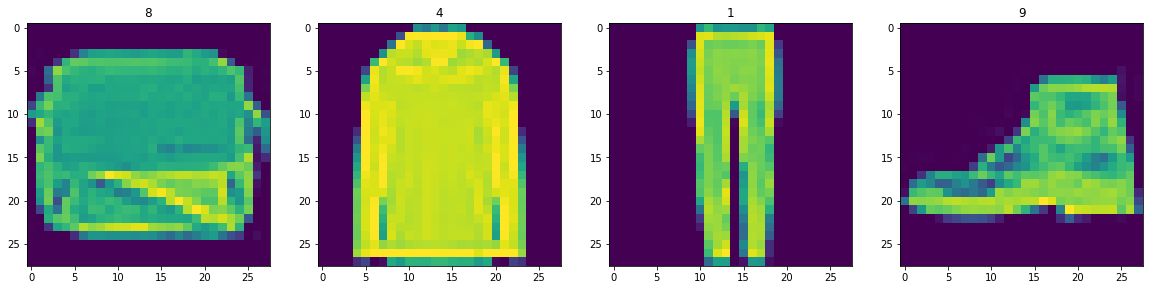

In [13]:
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx in range(4): 
    # Grab an image and label
    sample = data_iterator.next()
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(sample['image']))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(sample['label'])

**Data pre-processing**

In [14]:
# Scale images between 0 to 1 and return images only, remove lables
def scale_images(data): 
    image = data['image']
    return image / 255

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# Build a data pipline for tf using map, cache, shuffle, batch, prefetch
# Reload the dataset 
dataset = tfds.load('fashion_mnist', split='train')
# Running the dataset through the scale_images preprocessing step
dataset = dataset.map(scale_images) 
# Cache the dataset for that batch 
dataset = dataset.cache()
# Shuffle it up 
dataset = dataset.shuffle(60000)
# Batch into 128 images per sample
dataset = dataset.batch(128)
# Reduces the likelihood of bottlenecking 
dataset = dataset.prefetch(64)

In [17]:
dataset.as_numpy_iterator().next().shape

(128, 28, 28, 1)

**Build Neural Network**

In [18]:
# Import model components

# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

Build Generator

In [19]:
def build_generator(): 
    model = Sequential()
    
    # Takes in random values and reshapes it to 7x7x128
    # Beginnings of a generated image
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    
    # Upsampling block 1 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same')) # kernel size 5x5
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 2 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model

In [20]:
generator = build_generator()

In [21]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [22]:
img = generator.predict(np.random.randn(4,128,1))

1/1 [==============================] - 7s 7s/step


In [31]:
img # 4 random images are generated

array([[0.5038723 ],
       [0.49442464],
       [0.497538  ],
       [0.49686837],
       [0.50103617],
       [0.50622594],
       [0.5036599 ],
       [0.5073829 ],
       [0.50420886],
       [0.4992741 ],
       [0.4932761 ],
       [0.4945393 ],
       [0.4971286 ],
       [0.49185738],
       [0.4965588 ],
       [0.49752915],
       [0.5033396 ],
       [0.49836397],
       [0.50080323],
       [0.503296  ],
       [0.5076941 ],
       [0.5095441 ],
       [0.500348  ],
       [0.49936298],
       [0.49361292],
       [0.49650425],
       [0.49667275],
       [0.49943808]], dtype=float32)

1/1 [==============================] - 0s 16ms/step


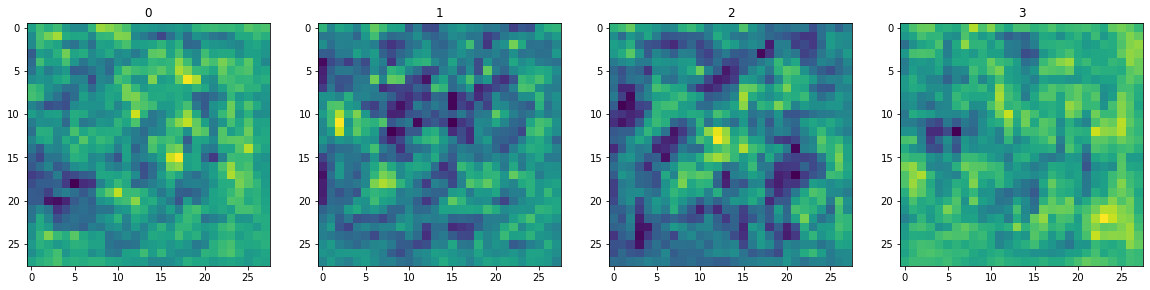

In [32]:
# Generate new fashion
img = generator.predict(np.random.randn(4,128,1))
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx, img in enumerate(img): 
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(idx)

**Build Discriminator**

In [24]:
def build_discriminator(): 
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid')) # 0 - real image, 1 - fake image
    
    return model 

In [25]:
discriminator = build_discriminator()

In [33]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [41]:
img = generator.predict(np.random.randn(4,128,1))

1/1 [==============================] - 0s 14ms/step


In [45]:
img.shape

(4, 28, 28, 1)

In [47]:
discriminator.predict(img)

1/1 [==============================] - 0s 14ms/step


array([[0.503694  ],
       [0.50377035],
       [0.50371385],
       [0.50365585]], dtype=float32)

**Construct Training Loop**

Setup Losses and Optimizers

In [48]:
# Adam is going to be the optimizer for both
from tensorflow.keras.optimizers import Adam
# Binary cross entropy is going to be the loss for both 
from tensorflow.keras.losses import BinaryCrossentropy

In [49]:
g_opt = Adam(learning_rate=0.0001) 
d_opt = Adam(learning_rate=0.00001) 
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

Build Subclassed Model

In [50]:
# Importing the base model class to subclass our training step 
from tensorflow.keras.models import Model

In [51]:
class FashionGAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class 
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        # Get the data 
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0) # combine all samples together
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # Apply backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [52]:
# Create instance of subclassed model
fashgan = FashionGAN(generator, discriminator)

In [53]:
# Compile the model
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

Build Callback

In [54]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [61]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

Train the model

In [59]:
!pwd

/content


In [62]:
# Recommend 2000 epochs
hist = fashgan.fit(dataset, epochs=20, callbacks=[ModelMonitor()])

Epoch 1/20
  6/469 [..............................] - ETA: 1:09 - d_loss: 0.2782 - g_loss: 6.0717

469/469 [==============================] - 72s 154ms/step - d_loss: 0.2767 - g_loss: 6.1172
Epoch 2/20
469/469 [==============================] - 72s 153ms/step - d_loss: 0.2745 - g_loss: 5.8920
Epoch 3/20
469/469 [==============================] - 72s 153ms/step - d_loss: 0.2729 - g_loss: 5.5164
Epoch 4/20
469/469 [==============================] - 72s 153ms/step - d_loss: 0.2717 - g_loss: 5.1280
Epoch 5/20
469/469 [==============================] - 71s 152ms/step - d_loss: 0.2707 - g_loss: 4.7800
Epoch 6/20
469/469 [==============================] - 72s 153ms/step - d_loss: 0.4529 - g_loss: 1.9148
Epoch 7/20
469/469 [==============================] - 72s 153ms/step - d_loss: 0.4416 - g_loss: 1.5488
Epoch 8/20
469/469 [==============================] - 72s 153ms/step - d_loss: 0.4238 - g_loss: 0.4732
Epoch 9/20
469/469 [==============================] - 72s 154ms/step - d_loss: 0.3658 - g_loss: 0.1653
Epoch 10/20
469/469 [==============================] - 72s 154ms/step - d_loss: 0.75

Review Performance

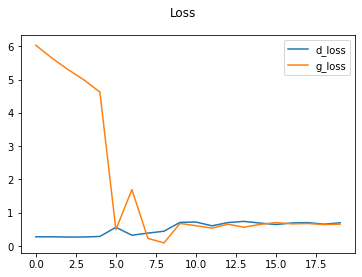

In [69]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()